## Plot results for Section 3.4

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import pymc as pm
import arviz as az
from haplm.hap_util import num_to_str, mat_by_marker

In [2]:
from matplotlib import rc, rcParams
# remove if tex not installed
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex = True)
rc('font', size=14)

# colors for plotting
colors = [
    '#1b9e77',
    '#d95f02',
    '#7570b3',
    '#e7298a',
    '#66a61e',
    '#e6ab02'
]

In [3]:
H = 8
N = 30 # number of data points
pool_size = 50
n_markers = 3
amat = mat_by_marker(n_markers)

In [4]:
with open('../../data/time-series/sim_data.pkl', 'rb') as fp:
    tmp = pkl.load(fp)
    p_true = tmp['p'] # H x T
    zs_true = tmp['z'] # N x H

In [5]:
t_obs = []
ns = []
ys = []
with open('../../data/time-series/time_series.data') as fp:
    for line in fp:
        tokens = line.split()
        t_obs.append(float(tokens[0]))
        ns.append(int(tokens[1]))
        ys.append(np.array([int(x) for x in tokens[2:]]))
t_obs = np.array(t_obs)

In [6]:
idata_exact = az.from_netcdf('../../data/time-series/psize50_m3_exact.netcdf')
idata_mn = az.from_netcdf('../../data/time-series/psize50_m3_mn_approx.netcdf')
idata_gibbs = az.from_netcdf(f'../../data/time-series/psize50_m3_gibbs.netcdf')

In [7]:
# wall time
for idata in [idata_exact, idata_mn, idata_gibbs]:
    print((idata.sample_stats.attrs['preprocess_time'] + idata.sample_stats.attrs['mcmc_walltime'])/60)

76.28053080240885
7.433839682737986
54.20547360976537


In [8]:
pess_exact = az.ess(idata_exact, var_names=['p'])['p'].values.flatten()
pess_gibbs = az.ess(idata_gibbs, var_names=['p'])['p'].values.flatten()
pess_mn = az.ess(idata_mn, var_names=['p'])['p'].values.flatten()

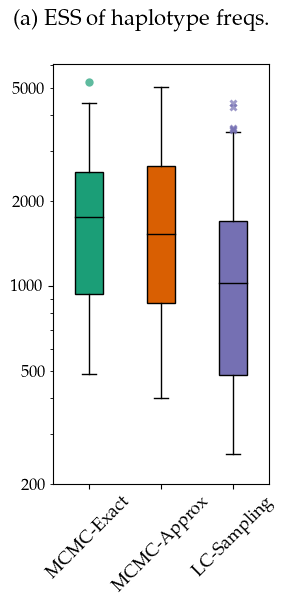

In [9]:
fig = plt.figure(figsize=(3, 6))

for i in range(3):
    pess = [pess_exact, pess_mn, pess_gibbs][i]
    method_name = ['MCMC-Exact', 'MCMC-Approx', 'LC-Sampling'][i]
    plt.boxplot([pess], positions=[i], labels=[method_name], widths=[0.4],
                patch_artist=True, boxprops=dict(facecolor=colors[i]),
                flierprops=dict(alpha=0.7, markerfacecolor=colors[i], markeredgecolor='none', 
                                markersize=6, marker='o^Xv'[i]),
                medianprops=dict(color='k'))
    

# boxp = plt.boxplot([pess_exact, pess_mn, pess_gibbs], labels=['MCMC-Exact', 'MCMC-Approx', 'LC-Sampling'],
#                    patch_artist=True, medianprops=dict(color='k'),
#                    flierprops=dict(alpha=0.7, markerfacecolor=colors[i], markeredgecolor='none', 
#                                    markersize=6, marker='o^Xv'[i]),)
# for patch, color in zip(boxp['boxes'], colors[:3]):
#     patch.set_facecolor(color)
plt.yscale('log')
plt.xticks(rotation=45)
plt.yticks([1000], [1000])
plt.yticks(list(range(200,1000,100)) + list(range(2000,7000,1000)),
            ['200'] + ['']*2 + ['500'] + ['']*4 + ['2000'] + ['']*2 + ['5000', ''],
            minor=True)

plt.tick_params(axis='x', which='both', labelsize=13)
plt.tick_params(axis='y', which='both', labelsize=12)
fig.suptitle(r'(a) ESS of haplotype freqs.', fontsize=16, y=0.97)
plt.subplots_adjust(top=0.88, left=0.2, right=0.92, bottom=0.18);
plt.savefig(f'ts_ess.png', dpi=200, facecolor='white'); 

In [10]:
with open(f'../../data/time-series/psize50_m3_exact_sumstats.pkl', 'rb') as fp:
    sumstats_exact = pkl.load(fp)

with open(f'../../data/time-series/psize50_m3_mn_approx_sumstats.pkl', 'rb') as fp:
    sumstats_mn = pkl.load(fp)
    
with open(f'../../data/time-series/psize50_m3_gibbs_sumstats.pkl', 'rb') as fp:
    sumstats_gibbs = pkl.load(fp)

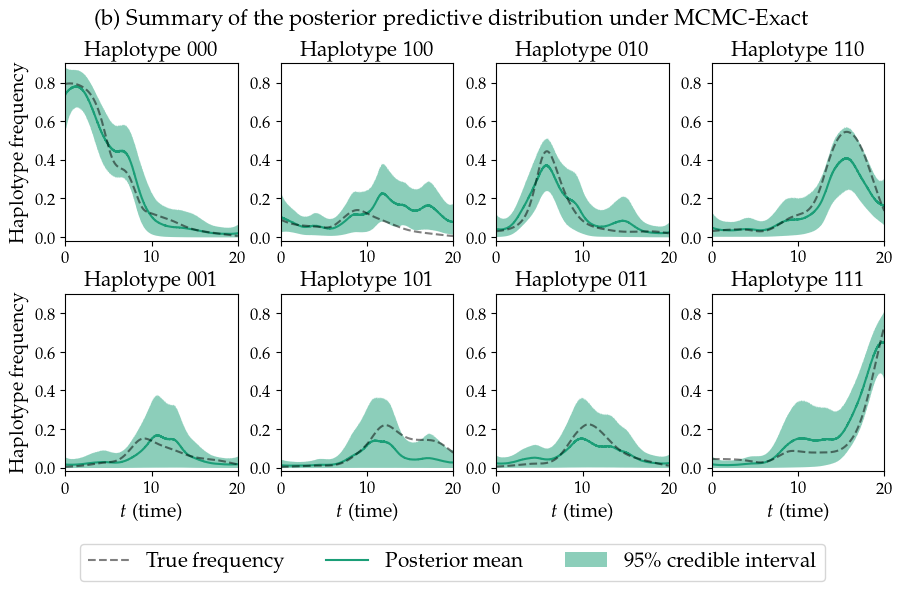

In [11]:
ts = np.arange(0, 20.00001, 0.001)
t_pred = np.arange(0, 20.001, 0.01)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 6))
for i in range(H):
    ax = axes[i//4][i%4]   
    ax.fill_between(t_pred,
                    sumstats_exact['quantiles'][1,:,i],
                    sumstats_exact['quantiles'][-2,:,i],
                    color=colors[0], alpha=0.5, linewidth=0, label='95\% credible interval')
    ax.plot(t_pred, sumstats_exact['mean'][:,i], color=colors[0], alpha=1, label='Posterior mean')
    ax.plot(ts, p_true[i], '--', color='k', alpha=0.5, label='True frequency')
    #ax.set_yscale('log')
    ax.set_ylim(-0.02, 0.9)
    ax.set_xlim(0, 20)
    if i // 4 == 1:
        ax.set_xticks(np.arange(0, 21, 10))
        ax.set_xlabel('$t$ (time)', fontsize=14)
    else:
        ax.set_xticks(np.arange(0, 21, 10))
    if i % 4 == 0:
        ax.set_ylabel(f'Haplotype frequency', fontsize=14)
    else:
        ax.set_yticks(np.arange(0, 0.81, 0.2))
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_title(f'Haplotype {num_to_str(i, 3)}', fontsize=15)

fig.suptitle('(b) Summary of the posterior predictive distribution under MCMC-Exact', fontsize=16, y=0.97)
handles, labels = ax.get_legend_handles_labels()
labels = labels[::-1]
handles = handles[::-1]
fig.legend(handles, labels, loc='lower center', ncols=len(labels), bbox_to_anchor=(0.5, 0), fontsize=15);

fig.subplots_adjust(top=0.88, bottom=0.2, left=0.07, right=0.98, wspace=0.25, hspace=0.3)
plt.savefig(f'ts_exact_trends.png', dpi=200, facecolor='white');

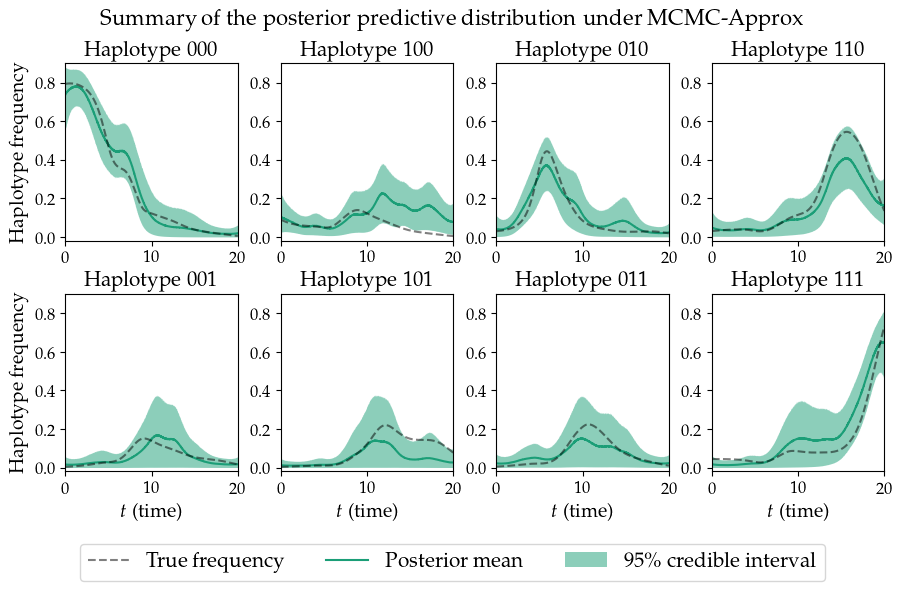

In [12]:
ts = np.arange(0, 20.00001, 0.001)
t_pred = np.arange(0, 20.001, 0.01)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 6))
for i in range(H):
    ax = axes[i//4][i%4]   
    ax.fill_between(t_pred,
                    sumstats_mn['quantiles'][1,:,i],
                    sumstats_mn['quantiles'][-2,:,i],
                    color=colors[0], alpha=0.5, linewidth=0, label='95\% credible interval')
    ax.plot(t_pred, sumstats_exact['mean'][:,i], color=colors[0], alpha=1, label='Posterior mean')
    ax.plot(ts, p_true[i], '--', color='k', alpha=0.5, label='True frequency')
    #ax.set_yscale('log')
    ax.set_ylim(-0.02, 0.9)
    ax.set_xlim(0, 20)
    if i // 4 == 1:
        ax.set_xticks(np.arange(0, 21, 10))
        ax.set_xlabel('$t$ (time)', fontsize=14)
    else:
        ax.set_xticks(np.arange(0, 21, 10))
    if i % 4 == 0:
        ax.set_ylabel(f'Haplotype frequency', fontsize=14)
    else:
        ax.set_yticks(np.arange(0, 0.81, 0.2))
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_title(f'Haplotype {num_to_str(i, 3)}', fontsize=15)

fig.suptitle('Summary of the posterior predictive distribution under MCMC-Approx', fontsize=16, y=0.97)
handles, labels = ax.get_legend_handles_labels()
labels = labels[::-1]
handles = handles[::-1]
fig.legend(handles, labels, loc='lower center', ncols=len(labels), bbox_to_anchor=(0.5, 0), fontsize=15);

fig.subplots_adjust(top=0.88, bottom=0.2, left=0.07, right=0.98, wspace=0.25, hspace=0.3)
plt.savefig(f'ts_mn_trends.png', dpi=200, facecolor='white');

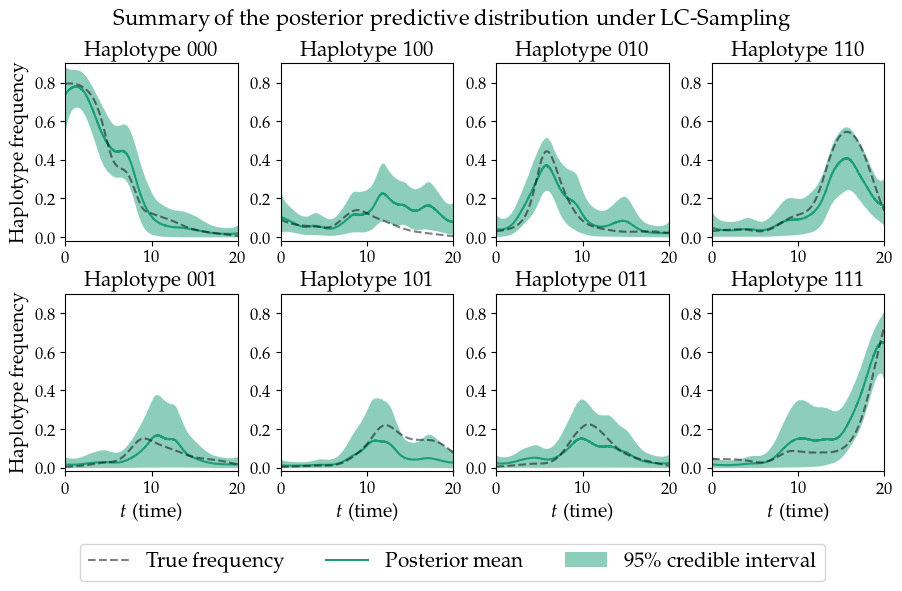

In [13]:
ts = np.arange(0, 20.00001, 0.001)
t_pred = np.arange(0, 20.001, 0.01)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 6))
for i in range(H):
    ax = axes[i//4][i%4]   
    ax.fill_between(t_pred,
                    sumstats_gibbs['quantiles'][1,:,i],
                    sumstats_gibbs['quantiles'][-2,:,i],
                    color=colors[0], alpha=0.5, linewidth=0, label='95\% credible interval')
    ax.plot(t_pred, sumstats_exact['mean'][:,i], color=colors[0], alpha=1, label='Posterior mean')
    ax.plot(ts, p_true[i], '--', color='k', alpha=0.5, label='True frequency')
    #ax.set_yscale('log')
    ax.set_ylim(-0.02, 0.9)
    ax.set_xlim(0, 20)
    if i // 4 == 1:
        ax.set_xticks(np.arange(0, 21, 10))
        ax.set_xlabel('$t$ (time)', fontsize=14)
    else:
        ax.set_xticks(np.arange(0, 21, 10))
    if i % 4 == 0:
        ax.set_ylabel(f'Haplotype frequency', fontsize=14)
    else:
        ax.set_yticks(np.arange(0, 0.81, 0.2))
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_title(f'Haplotype {num_to_str(i, 3)}', fontsize=15)

fig.suptitle('Summary of the posterior predictive distribution under LC-Sampling', fontsize=16, y=0.97)
handles, labels = ax.get_legend_handles_labels()
labels = labels[::-1]
handles = handles[::-1]
fig.legend(handles, labels, loc='lower center', ncols=len(labels), bbox_to_anchor=(0.5, 0), fontsize=15);

fig.subplots_adjust(top=0.88, bottom=0.2, left=0.07, right=0.98, wspace=0.25, hspace=0.3)
plt.savefig(f'ts_gibbs_trends.png', dpi=200, facecolor='white');

## Difference in summary statistics

In [14]:
exact_means = np.mean(np.vstack(idata_exact.posterior.p), axis=0)
exact_stds = np.std(np.vstack(idata_exact.posterior.p), axis=0)
gibbs_means = np.mean(np.vstack(idata_gibbs.posterior.p), axis=0)
gibbs_stds = np.std(np.vstack(idata_gibbs.posterior.p), axis=0)
mn_means = np.mean(np.vstack(idata_mn.posterior.p), axis=0)
mn_stds = np.std(np.vstack(idata_mn.posterior.p), axis=0)

In [15]:
np.abs(exact_means-gibbs_means).max()

0.010389949392691847

In [16]:
np.abs(exact_means-mn_means).max()

0.011842702592700899

In [17]:
np.abs(exact_stds-gibbs_stds).max()

0.003902193872713275

In [18]:
np.abs(exact_stds-mn_stds).max()

0.004636645197446387

## Plot joint distributions for $t=10$

In [19]:
exact_pred_tint = np.load(f'../../data/time-series/psize50_m3_exact_pred_samples_tint.npy')
mn_pred_tint = np.load(f'../../data/time-series/psize50_m3_mn_approx_pred_samples_tint.npy')
gibbs_pred_tint = np.load(f'../../data/time-series/psize50_m3_gibbs_pred_samples_tint.npy')

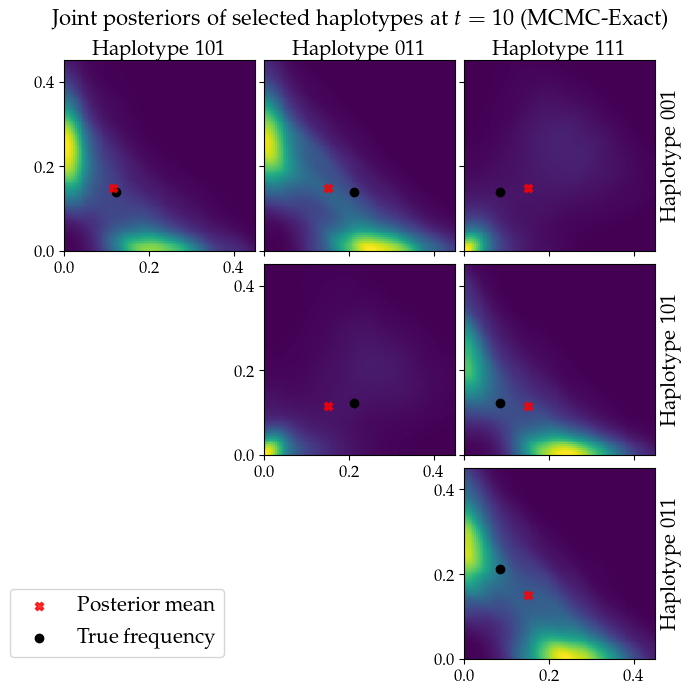

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12*0.6, 7))
gs = 128
for i in range(3):
    for j in range(i,3):
        h1, h2 = 4+i, 5+j
        ax = axes[i,j]
        v1, v2 = exact_pred_tint[:,10,h1], exact_pred_tint[:,10,h2]
        grid, xmin, xmax, ymin, ymax = az.stats.density_utils._fast_kde_2d(v2, v1, (gs, gs))
        x_x, y_y = np.mgrid[xmin:xmax+1e-9:(xmax-xmin)/(gs-1), ymin:ymax+1e-9:(ymax-ymin)/(gs-1)]
        ax.pcolormesh(x_x, y_y, grid);
        
        ax.scatter(sumstats_exact['mean'][1000,h2], sumstats_exact['mean'][1000,h1],
                   color='r', alpha=0.8, marker='X', label='Posterior mean', zorder=100)
        ax.scatter(p_true[h2,10000],p_true[h1,10000], 
                   color='k', label='True frequency', zorder=99)
        
        # ax.plot(p_true[h2,:],p_true[h1,:], '--', color='k')
        ax.set_xlim((0,0.45))
        ax.set_ylim((0,0.45))
        ax.set_aspect('equal')
       
        if j == 2:
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(f'Haplotype {num_to_str(h1, 3)}', fontsize=15)
        if i == 0:
            ax.xaxis.set_label_position('top')
            ax.set_xlabel(f'Haplotype {num_to_str(h2, 3)}', fontsize=15)
        if i != j:
            ax.set_xticks([0,0.2,0.4], ['']*3)
            ax.set_yticks([0,0.2,0.4], ['']*3)
        else:
            ax.set_xticks([0,0.2,0.4])
            ax.set_yticks([0,0.2,0.4])            
        ax.tick_params(axis='both', which='both', labelsize=12)
fig.delaxes(axes[1,0]);
fig.delaxes(axes[2,0]);
fig.delaxes(axes[2,1]);

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0, 0.04), fontsize=15);
fig.suptitle('Joint posteriors of selected haplotypes at $t=10$ (MCMC-Exact)', fontsize=16)
fig.subplots_adjust(top=0.91, bottom=0.05, left=0.09, right=0.91, wspace=0.05, hspace=0.05)
plt.savefig(f'ts_exact_joint_t10.png', dpi=200, facecolor='white');

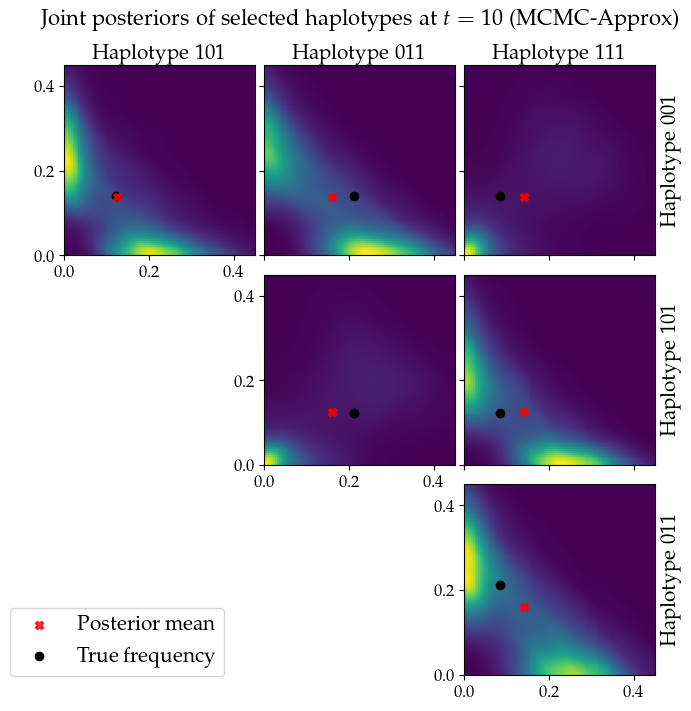

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12*0.6, 12*0.6))
gs = 128
for i in range(3):
    for j in range(i,3):
        h1, h2 = 4+i, 5+j
        ax = axes[i,j]
        v1, v2 = mn_pred_tint[:,10,h1], mn_pred_tint[:,10,h2]
        grid, xmin, xmax, ymin, ymax = az.stats.density_utils._fast_kde_2d(v2, v1, (gs, gs))
        x_x, y_y = np.mgrid[xmin:xmax+1e-9:(xmax-xmin)/(gs-1), ymin:ymax+1e-9:(ymax-ymin)/(gs-1)]
        ax.pcolormesh(x_x, y_y, grid);
        
        ax.scatter(sumstats_mn['mean'][1000,h2], sumstats_mn['mean'][1000,h1],
                   color='r', alpha=0.8, marker='X', label='Posterior mean', zorder=100)
        ax.scatter(p_true[h2,10000],p_true[h1,10000], 
                   color='k', label='True frequency', zorder=99)
        
        # ax.plot(p_true[h2,:],p_true[h1,:], '--', color='k')
        ax.set_xlim((0,0.45))
        ax.set_ylim((0,0.45))
        ax.set_aspect('equal')
        
        if j == 2:
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(f'Haplotype {num_to_str(h1, 3)}', fontsize=15)
        if i == 0:
            ax.xaxis.set_label_position('top')
            ax.set_xlabel(f'Haplotype {num_to_str(h2, 3)}', fontsize=15)
        if i != j:
            ax.set_xticks([0,0.2,0.4], ['']*3)
            ax.set_yticks([0,0.2,0.4], ['']*3)
        else:
            ax.set_xticks([0,0.2,0.4])
            ax.set_yticks([0,0.2,0.4])            
        ax.tick_params(axis='both', which='both', labelsize=12)
fig.delaxes(axes[1,0]);
fig.delaxes(axes[2,0]);
fig.delaxes(axes[2,1]);

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0, 0.04), fontsize=15);
fig.suptitle('Joint posteriors of selected haplotypes at $t=10$ (MCMC-Approx)', fontsize=16)
fig.subplots_adjust(top=0.91, bottom=0.05, left=0.09, right=0.91, wspace=0.05, hspace=0.05)
plt.savefig(f'ts_mn_joint_t10.png', dpi=200, facecolor='white');

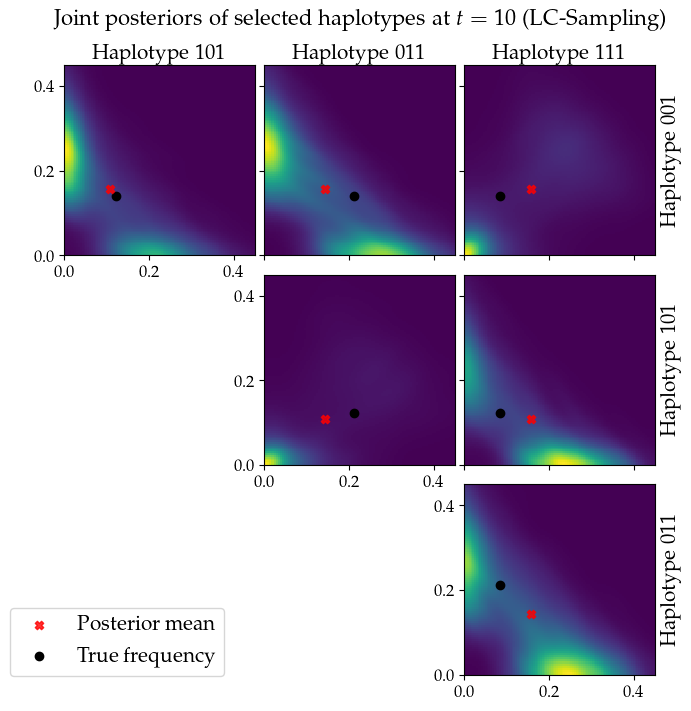

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12*0.6, 12*0.6))
gs = 128
for i in range(3):
    for j in range(i,3):
        h1, h2 = 4+i, 5+j
        ax = axes[i,j]
        v1, v2 = gibbs_pred_tint[:,10,h1], gibbs_pred_tint[:,10,h2]
        grid, xmin, xmax, ymin, ymax = az.stats.density_utils._fast_kde_2d(v2, v1, (gs, gs))
        x_x, y_y = np.mgrid[xmin:xmax+1e-9:(xmax-xmin)/(gs-1), ymin:ymax+1e-9:(ymax-ymin)/(gs-1)]
        ax.pcolormesh(x_x, y_y, grid);
        
        ax.scatter(sumstats_gibbs['mean'][1000,h2], sumstats_gibbs['mean'][1000,h1],
           color='r', alpha=0.8, marker='X', label='Posterior mean', zorder=100)
        ax.scatter(p_true[h2,10000],p_true[h1,10000], 
                   color='k', label='True frequency', zorder=99)
        
        # ax.plot(p_true[h2,:],p_true[h1,:], '--', color='k')
        ax.set_xlim((0,0.45))
        ax.set_ylim((0,0.45))
        ax.set_aspect('equal')
            
        if j == 2:
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(f'Haplotype {num_to_str(h1, 3)}', fontsize=15)
        if i == 0:
            ax.xaxis.set_label_position('top')
            ax.set_xlabel(f'Haplotype {num_to_str(h2, 3)}', fontsize=15)
        if i != j:
            ax.set_xticks([0,0.2,0.4], ['']*3)
            ax.set_yticks([0,0.2,0.4], ['']*3)
        else:
            ax.set_xticks([0,0.2,0.4])
            ax.set_yticks([0,0.2,0.4])            
        ax.tick_params(axis='both', which='both', labelsize=12)
fig.delaxes(axes[1,0]);
fig.delaxes(axes[2,0]);
fig.delaxes(axes[2,1]);

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0, 0.04), fontsize=15);
fig.suptitle('Joint posteriors of selected haplotypes at $t=10$ (LC-Sampling)', fontsize=16)
fig.subplots_adjust(top=0.91, bottom=0.05, left=0.09, right=0.91, wspace=0.05, hspace=0.05)
plt.savefig(f'ts_gibbs_joint_t10.png', dpi=200, facecolor='white');